# Tutorial

<b>Warning: it is necessary to use <u>setups='sg15'</u> in GPAW</b> (ONCV pseudopotentials)

In [25]:
from gpaw import GPAW, FermiDirac
from gpaw.wavefunctions.pw import PW
from ase.io import read
from TDDFT import TDDFT
import numpy as np
from tqdm import tqdm
from ase.units import Hartree, Bohr
import matplotlib.pyplot as plt
%matplotlib inline

c = 20
PW_cut=400
nbands=40
atoms = read('hBN.cif')
atoms.cell[2,2]=c
atoms.center()

calc = GPAW(mode=PW(PW_cut),xc='PBE',
            kpts={'size': (4, 4, 1), 'gamma': True},
            setups='sg15',nbands=nbands*2,
            occupations=FermiDirac(0.0001),
            convergence={'bands':nbands},
            symmetry='off',
            txt='calc.txt')

atoms.set_calculator(calc)
atoms.get_potential_energy()
calc.write('gs.gpw')

/home/yzhumagulov/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.ifft(a, n, axis)


# Initialization 

In [ ]:
tddft=TDDFT(calc,nbands)

 50%|█████     | 8/16 [03:24<03:11, 23.97s/it]

# Calculation of the dipole matrix
Сalculation of the dipole matrix occurs according to the following equation
$$ d_{nm}(k)=\int_\Omega dr \; u_{kn}^{*}(r) \; r \; u_{km}(r)$$
where $u_{kn}(r)$ - periodic part of Kohn-Sham wavefunction which is stored in <b>TDDFT.ukn</b>

$r$ - coordinate inside the elementary cell which is stored in <b>TDDFT.r</b>

$\Omega$ - volume of the elementary cell which is stored in <b>TDDFT.volume</b>

In [ ]:
direction=[0,0,1]
dipole=tddft.get_dipole_matrix(direction)
plt.title("Dipole matrix at K=0")
plt.imshow(np.abs(dipole[0]))
plt.colorbar()

In [ ]:
dipole_orbital=np.array([tddft.wk[k]*dipole[k].diagonal() for k in range(tddft.NK)]).sum(axis=0)

In [ ]:
tddft.wk

In [ ]:
mean=np.mean(dipole_orbital.real[:4])

In [ ]:
plt.plot(dipole_orbital.real-mean,'o')
plt.plot(dipole_orbital.imag)
plt.grid()

# Calculation of the Hartree matrix
Calculation of the Hartree matrix occurs according to following equation
$$ V^{H}_{nm}(k)=\int_\Omega dr \; u_{kn}^{*}(r) \; V_H(r) \; u_{km}(r)$$
$V_H(r)$ - Hartree potential which is obtained by solving Poisson equation using folowing equations:
$$n(G)=FFT(n(r)) \Rightarrow V_H(G)=-4\pi\frac{n(G)}{|G|^2} \Rightarrow V_H(r)=IFFT(V_H(G))$$
$$n(r)=2 \sum_{k}^{IBZ} w(k)\sum_n^{N_b}f_n\sum_m^{N_b} \left|c_{nm}(k)u_{km}(r)\right|^2$$
where $IBZ$ -irreducible Brillioun zone

$w(k)$ - weight of k-points in irreducible Brillioun zone which is stored in <b>TDDFT.w</b>

$f_n$ - occupation of Kohn-Sham orbitals which is stored in <b>TDDFT.f</b>

$c_{nm}(k)$ - wavefunction in second-quantization basis

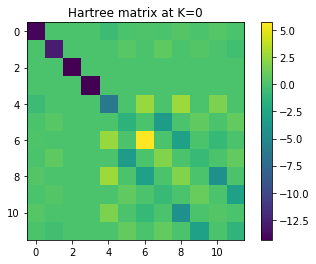

In [15]:
VH_matrix=tddft.get_Hartree_matrix()
plt.title("Hartree matrix at K=0")
plt.imshow(VH_matrix[0].real)
plt.colorbar()

# Calculation of the Fock matrix
Calculation of the Fock matrix occurs according to following equation
$$ V^{F}_{nm}(k)=-\sum^{occ}_l \sum_{q}^{BZ} \sum_{G} M^{*}_{ln}(k,q,G)M_{l,m}(k,q,G)v(q+G)$$
where $M_{n,m}(k,q,G)$ - pair-density which is stored in <b>TDDFT.M</b>
$$M_{n,m}(k,q,G)=IFFT\left(u_{k+q,n}^{*}(r)u_{k,n}(r)\right)$$
and $v(q+G)$ - Coloumb potential
$$v(q+G)=\frac{4\pi}{\left|q+G\right|^{2}}$$

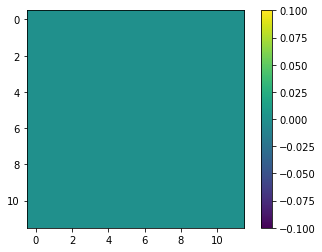

In [16]:
VF_matrix=tddft.get_Fock_matrix()
plt.imshow(VF_matrix[0].real)
plt.colorbar()

# Calculation of the LDA exchange matrix
Calculation of the LDA exchange matrix matrix occurs according to following equation
$$ V^{LDAx}_{nm}(k)=\int_\Omega dr \; u_{kn}^{*}(r) \; \left(-\frac{3n(r)}{\pi}\right)^{1/3} \; u_{km}(r)$$

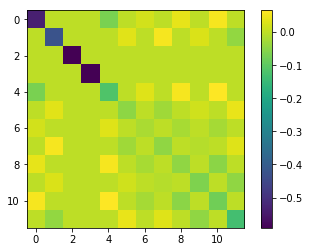

In [17]:
LDAx_matrix=tddft.get_LDA_exchange_matrix()
plt.imshow(LDAx_matrix[0].real)
plt.colorbar()

# Calculation of the LDA correlation matrix
Calculation of the LDA correlation matrix matrix occurs according to following equation
$$ V^{LDAx}_{nm}(k)=\int_\Omega dr \; u_{kn}^{*}(r) \; f_c(n(r)) \; u_{km}(r)$$
$f_c(n(r))$ parametrization taken from THE JOURNAL OF CHEMICAL PHYSICS 145, 157101 (2016)

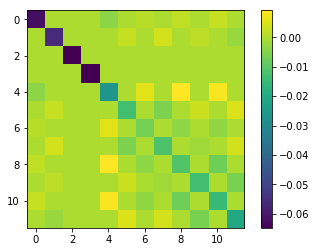

In [18]:
LDAc_matrix=tddft.get_LDA_correlation_matrix()
plt.imshow(LDAc_matrix[0].real)
plt.colorbar()

# TDDFT

In [21]:
dt=1;steps=2000;
E=np.zeros(steps);time=np.arange(steps)*dt
E[10]=1
result=tddft.propagate(dt=dt,steps=steps,E=E,operator=dipole)
spectrum=np.fft.fft(tddft.macro_dipole)
freq = np.fft.fftfreq(steps, d=dt)*Hartree*2*np.pi
spectrum=spectrum[np.argsort(freq)]
freq=np.sort(freq)
spectrum=np.abs(spectrum)**2

In [22]:
data = np.loadtxt('df.csv', delimiter=',')

# Set plotting range
xmin = 0.1
xmax = 30.0
inds_w = (data[:, 0] >= xmin) & (data[:, 0] <= xmax)

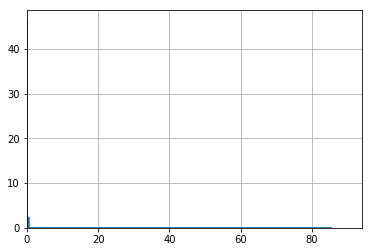

In [23]:
# plt.plot(omega*Hartree,epsilon.imag)
plt.plot(freq,spectrum/100,'-')
# plt.plot(data[inds_w, 0], 4 * np.pi * data[inds_w, 4],label='real')
# plt.legend(loc='best')
plt.xlim([0,None])
plt.ylim([0,None])
plt.grid()

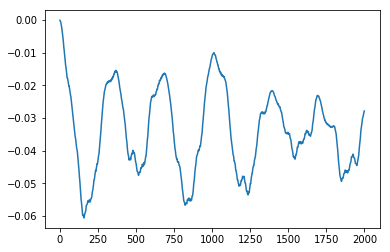

In [24]:
plt.plot(tddft.macro_dipole.real)

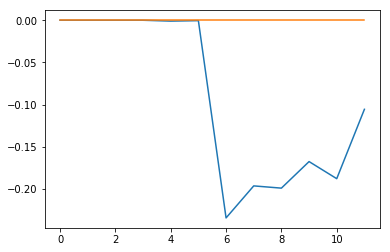

In [32]:
plt.plot(dipole_orbital.real)
plt.plot(dipole_orbital.imag)